# Basic Libraries

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

# provider = IBMQ.get_provider(hub='ibm-q')
# machine = provider.get_backend('ibmq_valencia')
from qiskit.test.mock import FakeLondon
machine = FakeLondon()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


basis_gates = machine_noise_model.basis_gates

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Important Functions

In [7]:
# Gate Insertion Functions
from GateInsertion_funcs import splitter, PiReader, u3PairAdder, cXPairAdder, GateInsertion, scalingCircuits #<---- main func

#Local Hamiltonian Function
from VQEHamiltonian_funcs import Hammifier

# Expectation Value/Running Functions
from Result_funcs import binaryToDecimal, dictToList, sampleExpecVal, countToEig, expecValForSamples, addDicts, evaluator, scaleEvaluator #<---- main function

#Extrapolation Functions
from Extrapolation_funcs import RichardsonExtrap_Fraction, MonteCarloError, plottingCalc


# Setting up Variational form

In [8]:
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

initial_state = HartreeFock(
4,
2,
'parity'
) 
var_form = UCCSD(
            num_orbitals=4,
            num_particles=2,
            initial_state=initial_state,
            qubit_mapping='parity'
        )

# Arguments

In [9]:


Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]



In [10]:
scales = [1, 1.1, 1.2, 1.3]

In [11]:
import math
from qiskit import ClassicalRegister

def Hammifier(circy, Hamiltonian):
    """
    Adding local hamiltonians and returning one for meas II, IZ . ZI. ZZ and other for XX
    """
    circuits = []
    for line in iter(Hamiltonian.splitlines()):
        circ = circy.copy()
        #print(line)
        for index in range(len(line)):
            op = line[index]

            ##do nothing if Z or I
            if(op == "X"): 
                #hadamard in u3
                #print(index)
                circ.u3(math.pi/2, 0, math.pi, index)
            elif(op == "Y"):
                circ.rx(pi/2, index)
        c = ClassicalRegister(2)
        circ.add_register(c)
        circ.measure([0], [0])
        circ.measure([1],[1])
        circuits.append(circ)
    return [circuits[0], circuits[4]]

In [25]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

b = 0
steps = []
zero_energies = []
unmit_energies = []
errors = []
def CircuitExtrapolator(param):
    '''
    Input: param (1D array) for circuit whose zero noise extrapolated energy to be calculated + some obvious param
    Output: Zero error energy + std_dev
    '''
    global b 
    b+=1
    print("---------------------------------------------------------------------------------")
    print(str(b) + "th evaluation where params are")
    print(param)
    scales = [1, 1.1, 1.2, 1.3, 1.4]
    Hamiltonian = """II\nIZ\nZI\nZZ\nXX"""
    Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]
    backend = simulator
    noise_model = machine_noise_model
    copies =50
    
    
    
    
    circ = var_form.construct_circuit(param).decompose()
    circuits = Hammifier(circ, Hamiltonian)
    scaled_circuits = scalingCircuits(circuits, scales, copies)
    means, std = scaleEvaluator(scaled_circuits, 1000, simulator, machine_noise_model, Hamiltonian, Hamiltonian_weights)
    zero_energy, error = plottingCalc(means, std, scales)
    clear_output()
    print(" and computed energy is: " + str(zero_energy))
    
    #Updating for plots 
    global zero_energies
    global errors
    global steps
    steps.append(b)
    zero_energies.append(zero_energy)
    errors.append(error)
    unmit_energies.append(means[0])
    
    #Plot 
    print(means)
    a = plt.figure()
    plt.ion
    plt.plot(steps,unmit_energies, marker= 'o', linestyle = '--', color = 'royalblue')
    plt.errorbar(steps, zero_energies, errors, marker = 'o', color = 'green', ecolor = 'springgreen', linestyle = '--', label = 'mitigated')
    plt.plot(steps, [-1.137 for i in steps], '--', color = 'black')
    plt.ylabel('Energies')
    plt.xlabel("Steps")
    plt.show()
    a.savefig("SPSAOct28.png", dpi= 1000)
    
    
    
    return zero_energy

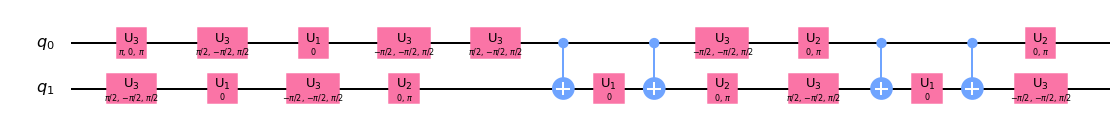

In [26]:
var_form.construct_circuit([0,0,0]).decompose().draw(output = 'mpl')

# Optimization

 and computed energy is: -1.103838612918917
[-1.0284781809189185, -1.0199194609189184, -1.0118731409189186, -1.0060586209189184, -0.9974581409189186]


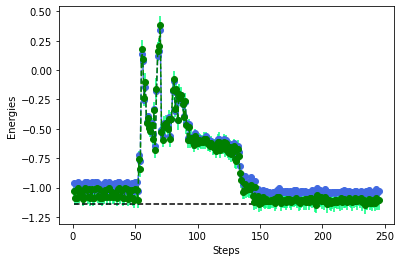

---------------------------------------------------------------------------------
246th evaluation where params are
[ 1.67436611  1.75128146 -1.59469234]


KeyboardInterrupt: 

In [27]:
from qiskit.aqua.components.optimizers import SPSA

optimizer = SPSA(maxiter=1000)
optimizer.optimize(num_vars = 3, objective_function= CircuitExtrapolator, gradient_function=None, variable_bounds=None, initial_point=[0,0,0])

In [28]:
zero_energies

[-1.0250782449189186,
 -1.085198292918919,
 -1.0870261329189184,
 -1.0072705809189186,
 -1.072515540918918,
 -1.0363062209189178,
 -1.033277764918918,
 -1.0934305729189187,
 -1.081690108918918,
 -1.0055156929189173,
 -1.0212216449189186,
 -1.0770972689189184,
 -1.0084895649189176,
 -1.0919354769189176,
 -1.0116127169189184,
 -1.0882363649189184,
 -1.0880394289189184,
 -1.0149923249189174,
 -1.0074537809189177,
 -1.070060172918918,
 -1.011346780918919,
 -1.0888692689189179,
 -1.0872751889189192,
 -1.0398104849189185,
 -1.076116860918919,
 -1.0209844049189185,
 -1.084162268918918,
 -1.0140953409189186,
 -1.0015937809189186,
 -1.0831826369189188,
 -1.0347348449189189,
 -1.0771979889189194,
 -1.070643980918919,
 -1.044300588918919,
 -1.0889871729189182,
 -1.0121849329189188,
 -1.0030970049189183,
 -1.0748932849189188,
 -1.0204261729189186,
 -1.0881562369189184,
 -1.0847099009189183,
 -1.0056768289189184,
 -1.0107889169189188,
 -1.0972917409189185,
 -1.0245057969189184,
 -1.088044908918918,

In [29]:
unmit_energies

[-0.9575651809189186,
 -1.0246552609189186,
 -1.0244254609189185,
 -0.9548132209189184,
 -1.0224840209189185,
 -0.9679777009189183,
 -0.9681243409189183,
 -1.0297508609189185,
 -1.0260096609189184,
 -0.9525970609189184,
 -0.9541884609189185,
 -1.0232980209189184,
 -0.9651961409189184,
 -1.0256350609189184,
 -0.9565438209189184,
 -1.0216977809189185,
 -1.0241549009189186,
 -0.9559445409189185,
 -0.9542513809189185,
 -1.0220465009189186,
 -0.9668895409189185,
 -1.0250418209189185,
 -1.0212403409189186,
 -0.9675335409189186,
 -1.0270275009189185,
 -0.9530458609189183,
 -1.0221283009189186,
 -0.9656243409189186,
 -0.9541347009189187,
 -1.0234431809189184,
 -0.9691805009189186,
 -1.0256742609189187,
 -1.0222257009189186,
 -0.9591255009189186,
 -1.0236821809189183,
 -0.9549508209189187,
 -0.9556656609189186,
 -1.0212238609189186,
 -0.9666985009189184,
 -1.0282542209189185,
 -1.0250768609189185,
 -0.9571249009189186,
 -0.9542317409189185,
 -1.0264663009189186,
 -0.9669183809189184,
 -1.024816

In [30]:
steps

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [32]:
errors

[0.06266465949050955,
 0.06580407351124519,
 0.06533831571163108,
 0.06745771811572493,
 0.0626620937217923,
 0.06813139880447878,
 0.061198752526394715,
 0.06742931524623935,
 0.0689607942772455,
 0.06219221388864532,
 0.06363266128741397,
 0.0632558406125859,
 0.06156770995142664,
 0.06677378587729496,
 0.0633240299337472,
 0.06789457889546589,
 0.05976926605949803,
 0.06575519616101977,
 0.06332809004631365,
 0.06490959840921445,
 0.06143142761683143,
 0.05750055933128045,
 0.06960845433451766,
 0.06532793911537965,
 0.06682201018538803,
 0.06762415524263554,
 0.0662128553373862,
 0.060421777109264586,
 0.06147634065539104,
 0.06452517209436333,
 0.06574004619335524,
 0.06378169803327251,
 0.061593274911340375,
 0.06401996269379165,
 0.06627903539767888,
 0.06152606493747904,
 0.06493022767791749,
 0.06156366858849047,
 0.06401602097485902,
 0.06495749653745543,
 0.060532028075042,
 0.057770937621082145,
 0.06030306413324671,
 0.06371615015623752,
 0.06434556317920954,
 0.0646820648